In [1]:
import osmnx as ox
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import random as rd
from IPython.display import clear_output
from shapely.wkt import loads as load_wkt
import matplotlib.cm as cm
import time
import math
ox.config(log_console=True, use_cache=True)

C:\Users\Vinicius Fernandes\.conda\envs\ox\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Vinicius Fernandes\.conda\envs\ox\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\Vinicius Fernandes\.conda\envs\ox\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


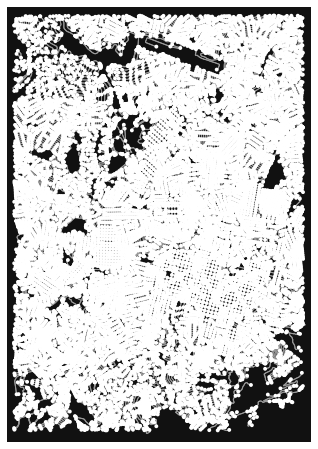

In [2]:
#importando as informações do Open Street Map e plotando

#definindo os limites da área analisada (Belo Horizonte)
#buscando as informações para andar, dessa forma não há restrições da direção para andar

#limites completos
#limite_superior = -19.7961
#limite_inferior = -20.0056
#limite_esquerdo = -44.0418
#limite_direito = -43.8684

#mapa reduzido
limite_superior = -19.8378
limite_inferior = -19.9785
limite_esquerdo = -44.0112
limite_direito = -43.9069

G = ox.graph_from_bbox(limite_superior,limite_inferior,limite_esquerdo,limite_direito,network_type='walk')

fig, ax = ox.plot_graph(G)

In [6]:
#importando todos os endereços das Drogarias Araujos dentro da região analisada
#importando também todas as latitudes e longitudes dessas araújos
df = pd.read_excel(r'C:\Users\Vinicius Fernandes\Documents\GitHub\TCC\Dados\lista_enderecos_araujo\lista_enderecos_completa.xlsx',sheet_name='lista_completa')
df = pd.concat([df[['enderecos']], df['coordenadas'].str.split(', ', expand=True)], axis=1)
df[0] = pd.to_numeric(df[0])
df[1] = pd.to_numeric(df[1])

#removendo araujos que não estão no limite definido
df = df[(df[0]< limite_superior) & (df[0]> limite_inferior) & (df[1]> limite_esquerdo) & (df[1]< limite_direito)]
df = df.reset_index(drop=True)

df

267


,enderecos,0,1
0,"Rua Curitiba, 327, Centro",-19.915654,-43.940298
1,"Rua Curitiba, 729, Centro",-19.919201,-43.941317
2,"Avenida Augusto de Lima, 744, Centro",-19.922607,-43.942935
3,"Rua da Bahia, 1070, Centro",-19.924362,-43.937421
4,"Avenida Afonso Pena, 2700, Funcionários",-19.935060,-43.929023
...,...,...,...
133,"Avenida Guaicuí, 660, Coração de Jesus",-19.947244,-43.955095
134,"Avenida Dom Pedro II, 1950, Carlos Prates",-19.907935,-43.959709
135,"Avenida Presidente Carlos Luz, 3001, Caiçaras",-19.891014,-43.967874
136,"Rua Vitório Marçola, 643, Anchieta",-19.947377,-43.924611


In [ ]:
#df.to_excel('araujos.xlsx')

In [ ]:
#método para encontrar o nó mais próximo

#criando duas listas em branco
    #uma para guardar somente o ID do nó
    #uma para guardar ID do nó, latitude e longitude desse nó

nodes_araujos = []
nodes_araujos_completos = []

for i in range(len(df)):
    #para cada endereço de araujo no dataframe, pega-se a latitude e longitude, e a distância inicial é infinita
    coordenada_lat = df.loc[i,0]
    coordenada_long = df.loc[i,1]
    distancia_node = 99999999999999
    for node_teste in G.nodes:
        #para cada nó do grafo completo, é calculada a hipotenusa (distância em graus) entre a araujo analisada e o nó
        
        coordenada_lat_teste = G.nodes[node_teste]['y']
        coordenada_long_teste = G.nodes[node_teste]['x']
        new_distancia_node = ((coordenada_lat-coordenada_lat_teste)**2 + (coordenada_long-coordenada_long_teste)**2)**(1/2)
        
        
        if new_distancia_node < distancia_node:
            #se a hipotenusa desse nó for menor que última, as informações são armazenadas nas listas 
            
            distancia_node = new_distancia_node
            origin_node = node_teste
    
    nodes_araujos.append(origin_node)
    nodes_araujos_completos.append([origin_node,G.nodes[origin_node]['y'],G.nodes[origin_node]['x']])

In [ ]:
nodes_araujos

In [ ]:
nodes_araujos_completos

In [ ]:
#transformando os nós e arestas em dataframes

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True) 

nodes['menor_distancia_para_araujo_bfs'] = 0
nodes['araujo_mais_proxima_bfs'] = 0
nodes['menor_distancia_para_araujo_djikstra'] = 0
nodes['araujo_mais_proxima_djikstra'] = 0
nodes['menor_distancia_para_araujo_astar'] = 0
nodes['araujo_mais_proxima_astar'] = 0



In [ ]:
nodes

In [ ]:
edges

In [ ]:
#buscando as 3 araújos mais próximas em área

#criando uma lista em branco para armezar as informações
node_araujos_busca = []
#valor do passo que será acrescido (em graus) a cada loop
step = 0.0005

start_time = time.time()

for node in G.nodes:
    
    
    #para cada nó do grafo, é criada uma lista em branco para armazenar quais araújos serão buscadas nos médotos de encontrar o caminho mais curto
    
    araujos_busca = []
    
    #valor do primeiro passo
    n_step = 1
        
    while len(araujos_busca) < 3:
        
        #o loop se mantém até que sejam encontradas as 3 araújos mais próximas em raio
        
        
        for index_node_araujo in range(len(nodes_araujos_completos)):
            
            try:
                
                #para cada nó do grafo, é verificado se alguma Araújo está dentro do área análise
                #a área é aumentada progressivamente somando-se à coordenada inicial: o valor do passo(step)*número de loops(n_step) 
                
                y_mais = G.nodes[node]['y'] + (n_step * step)
                y_menos = G.nodes[node]['y'] - (n_step * step)
                x_mais = G.nodes[node]['x'] + (n_step * step)
                x_menos = G.nodes[node]['x'] - (n_step * step)


                y_teste = nodes_araujos_completos[index_node_araujo][1]
                x_teste = nodes_araujos_completos[index_node_araujo][2]

                if y_teste<y_mais and y_teste>y_menos and x_teste<x_mais and x_teste>x_menos and nodes_araujos_completos[index_node_araujo][0] not in araujos_busca:
                    araujos_busca.append(nodes_araujos_completos[index_node_araujo][0])

                    #se a araújo em análise estiver dentro da área naquele passo, é acrescida à lista
                    
            except IndexError:
                break
        
        
        
        #se ainda não foram encontradas 3 araújos, é acrescido mais um passo à área analisada
        n_step += 1
        
        
    node_araujos_busca.append([node,araujos_busca])
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
node_araujos_busca

In [ ]:
#transformando as arestas em lista para montar grafos

edges_list = list(G.edges)
edges_list

In [ ]:
#montando grafo para breadth search a partir da lista de arestas

graph_breadth_search = {}

start_time = time.time()
for node_index_graph in range(len(edges_list)):
    try:
        graph_breadth_search[edges_list[node_index_graph][0]].append(edges_list[node_index_graph][1])
    except AttributeError:
        graph_breadth_search[edges_list[node_index_graph][0]] = [edges_list[node_index_graph][1]]
    except KeyError:
        graph_breadth_search[edges_list[node_index_graph][0]] = [edges_list[node_index_graph][1]]

print("--- %s seconds ---" % (time.time() - start_time))
graph_breadth_search

In [ ]:
def bfs(graph, start, end):
    # maintain a queue of paths
    queue = []
    # push the first path into the queue
    queue.append([start])
    #count = 0
    while queue:
        #print('queue',queue)
        # get the first path from the queue
        path = queue.pop(0)
        #print('path',path)
        # get the last node from the path
        node = path[-1]
        #print('node',node)
        # path found
        if node == end:
            return path
        # enumerate all adjacent nodes, construct a 
        # new path and push it into the queue
        for adjacent in graph.get(node, []):
            #print('adjacent',adjacent)
            new_path = list(path)
            new_path.append(adjacent)
            queue.append(new_path)
        #print('queue',queue)
        #count += 1
        #print(count,'\n\n')

In [ ]:
#aplicando breadth search

for node_index_breadth_search in range(len(node_araujos_busca)):
    start_time = time.time()
    
    node = node_araujos_busca[node_index_breadth_search][0]
    
    route_length = 99999999999999
    
    for araujo_index in range(len(node_araujos_busca[node_index_breadth_search][1])):
        araujo = node_araujos_busca[node_index_breadth_search][1][araujo_index]
        
        
        path_breadth_search = bfs(graph_breadth_search, node, araujo)

        
        total_lenght_breadth_search = 0
        for index_path_breadth_search in range(len(path_breadth_search)-1):
            lenght_node = graph_djikstra[path_breadth_search[index_path_breadth_search]][path_breadth_search[index_path_breadth_search+1]]
            total_lenght_breadth_search += lenght_node
            
        #print(total_lenght_astar)
        
        if total_lenght_breadth_search < route_length:
            route_length = total_lenght_breadth_search
            araujo_proxima = araujo
            
            
    nodes['menor_distancia_para_araujo'][node] = route_length
    nodes['araujo_mais_proxima'][node] = araujo_proxima
        
    
    #print('\n\n\n')


    print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#montando grafo para djikstra a partir da lista de arestas

graph_djikstra = {}
node_analise = 0

start_time = time.time()
for node_index_graph in range(len(edges_list)):

    node_to_append = edges_list[node_index_graph][0]
    length = G[edges_list[node_index_graph][0]][edges_list[node_index_graph][1]][0]['length']
    #print(node_to_append,node_analise)
    if node_to_append != node_analise:
        #se for diferente, vai criar uma nova dash table dentro do grafo
        graph_djikstra[edges_list[node_index_graph][0]] = {}
        graph_djikstra[edges_list[node_index_graph][0]][edges_list[node_index_graph][1]] = length
        node_analise = node_to_append
        #print('novo nó')
    else:
        graph_djikstra[edges_list[node_index_graph][0]][edges_list[node_index_graph][1]] = length
        #print('velho nó')

print("--- %s seconds ---" % (time.time() - start_time))    
graph_djikstra

In [ ]:
def dijkstra(graph, start, end):
    
    nodes_djikstra = tuple(graph.keys())
    
    alvos = end
    alvo_araujo_encontrado = False
    
    unvisited = {node: None for node in nodes_djikstra} #using None as +inf
    visited = {}
    node_djikstra = start
    current = node_djikstra
    currentDistance = 0
    unvisited[current] = currentDistance
    
    while alvo_araujo_encontrado == False :
        for neighbour, distance in graph[current].items():
            if neighbour not in unvisited: continue
            newDistance = currentDistance + distance
            if unvisited[neighbour] is None or unvisited[neighbour] > newDistance:
                unvisited[neighbour] = newDistance
        visited[current] = currentDistance
        del unvisited[current]
        if not unvisited: break
        candidates = [node for node in unvisited.items() if node[1]]
        current, currentDistance = sorted(candidates, key = lambda x: x[1])[0]
        
        for alvo_araujo in alvos:
            if alvo_araujo in visited:
                index_alvo_araujo_encontrado = alvo_araujo
                alvo_araujo_encontrado = True
                break
    
    lenght_djikstra = visited[alvo_araujo]
    araujo_proxima_djikstra = index_alvo_araujo_encontrado
    
    return lenght_djikstra,araujo_proxima_djikstra

In [ ]:
start_time = time.time()

for node_djikstra_index in range(len(node_araujos_busca)):
    
    resultado_djikstra = dijkstra(graph_djikstra, node_araujos_busca[node_djikstra_index][0], node_araujos_busca[node_djikstra_index][1])
    
    nodes['menor_distancia_para_araujo'][node_djikstra] = resultado_djikstra[0]
    nodes['araujo_mais_proxima'][node_djikstra] = resultado_djikstra[1]    
    
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#aplicando método de djikstra (ainda não otimizado)

nodes_djikstra = tuple(graph_djikstra.keys())
distances_djikstra = graph_djikstra


start_time = time.time()
for node_djikstra_index in range(len(node_araujos_busca)):
    
    
    
    alvos = node_araujos_busca[node_djikstra_index][1]
    alvo_araujo_encontrado = False


    unvisited = {node: None for node in nodes_djikstra} #using None as +inf
    visited = {}
    node_djikstra = node_araujos_busca[node_djikstra_index][0]
    current = node_djikstra
    currentDistance = 0
    unvisited[current] = currentDistance

    while alvo_araujo_encontrado == False :
        for neighbour, distance in distances_djikstra[current].items():
            if neighbour not in unvisited: continue
            newDistance = currentDistance + distance
            if unvisited[neighbour] is None or unvisited[neighbour] > newDistance:
                unvisited[neighbour] = newDistance
        visited[current] = currentDistance
        ultimo_visitado = current
        del unvisited[current]
        if not unvisited: break
        candidates = [node for node in unvisited.items() if node[1]]
        current, currentDistance = sorted(candidates, key = lambda x: x[1])[0]

        if ultimo_visitado in alvos:
            alvo_araujo_encontrado = True
            alvo_araujo = ultimo_visitado


    lenght_djikstra = visited[alvo_araujo]
    araujo_proxima_djikstra = alvo_araujo
        
    nodes['menor_distancia_para_araujo'][node_djikstra] = lenght_djikstra
    nodes['araujo_mais_proxima'][node_djikstra] = araujo_proxima_djikstra
    print(node_djikstra_index)
    
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#montando grafo para A* a partir do grafo de djikstra (a estrutura é a mesma, só muda o formato dos dados)

graph_astar = {}
for each_key in graph_djikstra:
    lista_astar = []
    for each_subkey in graph_djikstra[each_key]:
        lista_astar.append((each_subkey,graph_djikstra[each_key][each_subkey]))
    
    graph_astar[each_key] = lista_astar

graph_astar

In [ ]:
#calculando os valores heuristicos de cada nó no grafo para cada araújo

valores_heuristicos = {}

start_time = time.time()

for node_araujo in range(len(nodes_araujos_completos)):
    
    valores_heuristicos[nodes_araujos_completos[node_araujo][0]] = {}
    lat_node_araujo = nodes_araujos_completos[node_araujo][1]
    long_node_araujo = nodes_araujos_completos[node_araujo][2]
       
    for node_mapa in G.nodes:
        
        #para cada araújo, é calculada a distância de todos os outros pontos do mapa até ela
        
        lat_node_mapa = G.nodes[node_mapa]['y']
        long_node_mapa = G.nodes[node_mapa]['x']
        
        dif_lat = lat_node_araujo - lat_node_mapa
        dif_long = long_node_araujo - long_node_mapa
        
        #como as informações estão graus (coordenadas geográficas)
        #é necessário converter a distância em graus para metros
        #já que o "peso" aplicado no algoritmo também está em metros
        
        dist_lat = dif_lat * 111320
        dist_long = dif_long * 40075000 * math.cos(math.radians((lat_node_araujo+lat_node_mapa)/2)) / 360
        
        dist_reta = ((dist_lat ** 2)+(dist_long ** 2))**(1/2)
        
        valores_heuristicos[nodes_araujos_completos[node_araujo][0]][node_mapa] = dist_reta

print("--- %s seconds ---" % (time.time() - start_time))
valores_heuristicos

In [ ]:
#definindo função para método A*

from collections import deque
 
class Graph:
    def __init__(self, adjac_lis):
        self.adjac_lis = adjac_lis
 
    def get_neighbors(self, v):
        return self.adjac_lis[v]
 
    
    def h(self, n):
        
        H = valores_heuristicos[araujo]
 
        return H[n]
 
    def a_star_algorithm(self, start, stop):
        # In this open_lst is a lisy of nodes which have been visited, but who's 
        # neighbours haven't all been always inspected, It starts off with the start 
  #node
        # And closed_lst is a list of nodes which have been visited
        # and who's neighbors have been always inspected
        open_lst = set([start])
        closed_lst = set([])
 
        # poo has present distances from start to all other nodes
        # the default value is +infinity
        poo = {}
        poo[start] = 0
 
        # par contains an adjac mapping of all nodes
        par = {}
        par[start] = start
 
        while len(open_lst) > 0:
            n = None
 
            # it will find a node with the lowest value of f() -
            for v in open_lst:
                if n == None or poo[v] + self.h(v) < poo[n] + self.h(n):
                    n = v;
 
            if n == None:
                print('Path does not exist!')
                return None
 
            # if the current node is the stop
            # then we start again from start
            if n == stop:
                reconst_path = []
 
                while par[n] != n:
                    reconst_path.append(n)
                    n = par[n]
 
                reconst_path.append(start)
 
                reconst_path.reverse()
 
                #print('Path found: {}'.format(reconst_path))
                return reconst_path
 
            # for all the neighbors of the current node do
            for (m, weight) in self.get_neighbors(n):
              # if the current node is not presentin both open_lst and closed_lst
                # add it to open_lst and note n as it's par
                if m not in open_lst and m not in closed_lst:
                    open_lst.add(m)
                    par[m] = n
                    poo[m] = poo[n] + weight
 
                # otherwise, check if it's quicker to first visit n, then m
                # and if it is, update par data and poo data
                # and if the node was in the closed_lst, move it to open_lst
                else:
                    if poo[m] > poo[n] + weight:
                        poo[m] = poo[n] + weight
                        par[m] = n
 
                        if m in closed_lst:
                            closed_lst.remove(m)
                            open_lst.add(m)
 
            # remove n from the open_lst, and add it to closed_lst
            # because all of his neighbors were inspected
            open_lst.remove(n)
            closed_lst.add(n)
 
        print('Path does not exist!')
        return None

In [ ]:
#Aplicando A*

graph1 = Graph(graph_astar)


start_time = time.time()
for node_index_astar in range(len(node_araujos_busca)):
    
    
    node = node_araujos_busca[node_index_astar][0]
    
    route_length = 99999999999999
    
    for araujo_index in range(len(node_araujos_busca[node_index_astar][1])):
        
        
        araujo = node_araujos_busca[node_index_astar][1][araujo_index]
        
        path_astar = graph1.a_star_algorithm(node, araujo)
        
        #como a função não retorna a distância, e sim o caminho
        #é necessário pegar a distância de cada aresta no caminho encontrado
        #e converter para metros
        
        total_lenght_astar = 0
        for index_path_astar in range(len(path_astar)-1):
            lenght_node = graph_djikstra[path_astar[index_path_astar]][path_astar[index_path_astar+1]]
            total_lenght_astar += lenght_node
        
        
        if total_lenght_astar < route_length:
            route_length = total_lenght_astar
            araujo_proxima = araujo
            
    nodes['menor_distancia_para_araujo'][node] = route_length
    nodes['araujo_mais_proxima'][node] = araujo_proxima
        
    
    


print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
def get_colors(n, cmap='seismic', start=0., stop=1.):

    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, 1) for r, g, b, _ in colors]
    return colors

def get_node_colors_by_attr(G, attr, cmap='seismic', start=0, stop=1, na_color='none'):

    #num_bins = len(G.nodes())
    num_bins = 10
    
    bin_labels = range(num_bins)
    
    attr_values = pd.Series(nodes[attr].values)  # Cretaes a dataframe ith the attribute of each node
    
    cats = pd.qcut(x=attr_values, q=num_bins, labels=bin_labels)  # Puts the values in bins
    
    colors = get_colors(num_bins, cmap, start, stop)  #List of colors of each bin
    node_colors = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]

    return node_colors

In [ ]:
nc = get_node_colors_by_attr(G, attr='menor_distancia_para_araujo')
nc

In [ ]:
ns = [0]*len(G.nodes())
k = 0
for node in G.nodes():
    for node_araujo in nodes_araujos:
        #print(node)
        #print(node_araujo)
        if node == node_araujo:
            nc[k] = 'green'
            ns[k] = 30
            break
            #print('chegou aqui')
        else:
            ns[k] = 1
    k += 1

In [ ]:
start_time = time.time()

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.5, bgcolor = 'white', show=False)
cmap = plt.cm.get_cmap('seismic')
norm=plt.Normalize(vmin=nodes['menor_distancia_para_araujo'].min(), vmax=nodes['menor_distancia_para_araujo'].max())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')
cb.set_label('menor_distancia_para_araujo', fontsize = 20)
fig.savefig('teste.png')

print("--- %s seconds ---" % (time.time() - start_time))